## Imports

In [1]:
import os
import sys
sys.path.insert(0, '../utils')
from transfer_model import NTLModel
import transfer_utils 
import model_utils
import data_utils

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

import torchsummary
import torchvision
import torch

import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

use_gpu = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(use_gpu)
print("Using gpu: ", use_gpu)

%load_ext autoreload
%autoreload 2

Using gpu:  cpu


## File Locations

In [2]:
# Google Cloud Storage
bucket_name = 'tm-geospatial'
directory = 'poverty-prediction-datasets'
image_directory = directory + '/images'

# Destination files
report_file = '../data/images/report/report.csv'
dhs_indicators_file = '../data/dhs_indicators.csv'
nightlights_unstacked_file = '../data/nightlights_unstacked.csv'

gsm_data_dir = '../data/images/' 
model_file = '../data/model.pt'
feature_embeddings_file = '../data/embeddings.csv'
embeddings_indicators_file = '../data/indicators.csv'

# Test images for sanity checking purposes
high1_file = '../data/test_images/high1.jpg'
high2_file = '../data/test_images/high2.jpg'
low1_file = '../data/test_images/low1.jpg'
low2_file = '../data/test_images/low2.jpg'

## Download Files

In [3]:
data_utils.download_from_bucket('high1.jpg', image_directory, high1_file, bucket_name);
data_utils.download_from_bucket('high2.jpg', image_directory, high2_file, bucket_name);
data_utils.download_from_bucket('low1.jpg', image_directory, low1_file, bucket_name);
data_utils.download_from_bucket('low2.jpg', image_directory, low2_file, bucket_name);
data_utils.download_from_bucket('model.pt', directory, model_file, bucket_name);

../data/test_images/high1.jpg successfully downloaded
../data/test_images/high2.jpg successfully downloaded
../data/test_images/low1.jpg successfully downloaded
../data/test_images/low2.jpg successfully downloaded


## Load Datasets

In [ ]:
report = pd.read_csv(report_file)
nightlights_unstacked = pd.read_csv(nightlights_unstacked_file)
dhs_indicators = pd.read_csv(dhs_indicators_file)

## Instantiate Transfer Model

In [4]:
# Load data
dataloaders, dataset_sizes, class_names = transfer_utils.load_transform_data(
    data_dir=gsm_data_dir, batch_size=4
)

# Instantiate model
model = torchvision.models.vgg16(pretrained=True)
model = NTLModel(model, len(class_names))
if use_gpu == "cuda":
    model = model.cuda()
    
# Load saved model
checkpoint = torch.load(model_file)
model.load_state_dict(checkpoint['state_dict'])

# Visualize model
torchsummary.summary(model, (3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 400, 400]           1,792
              ReLU-2         [-1, 64, 400, 400]               0
            Conv2d-3         [-1, 64, 400, 400]          36,928
              ReLU-4         [-1, 64, 400, 400]               0
         MaxPool2d-5         [-1, 64, 200, 200]               0
            Conv2d-6        [-1, 128, 200, 200]          73,856
              ReLU-7        [-1, 128, 200, 200]               0
            Conv2d-8        [-1, 128, 200, 200]         147,584
              ReLU-9        [-1, 128, 200, 200]               0
        MaxPool2d-10        [-1, 128, 100, 100]               0
           Conv2d-11        [-1, 256, 100, 100]         295,168
             ReLU-12        [-1, 256, 100, 100]               0
           Conv2d-13        [-1, 256, 100, 100]         590,080
             ReLU-14        [-1, 256, 1

## Visualize Nighttime Light Intensity Classification Predictions

<Figure size 432x288 with 0 Axes>

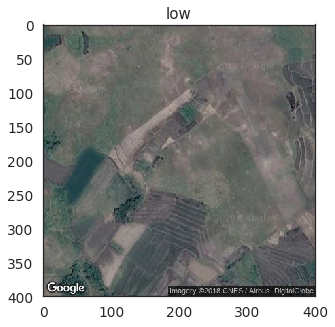

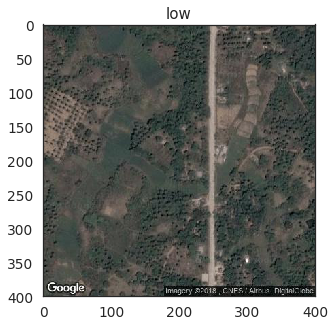

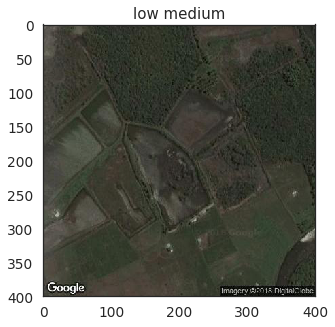

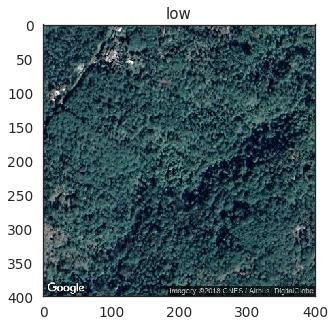

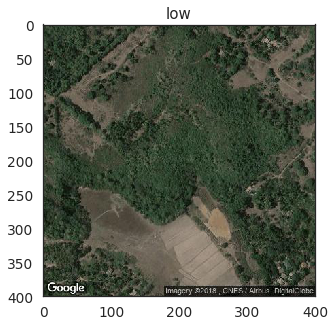

In [5]:
transfer_utils.visualize_model(model, dataloaders, class_names, 5, size=(5,5));

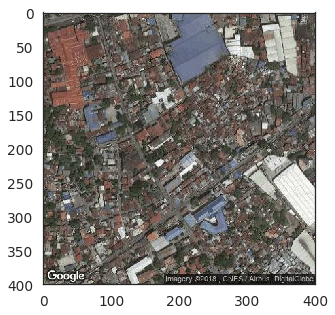

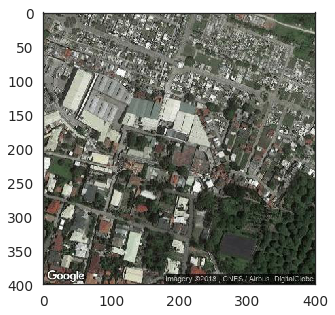

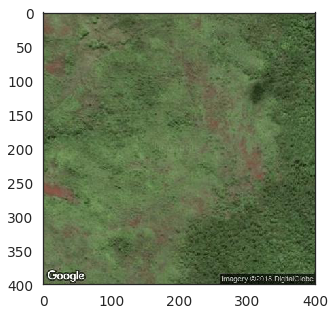

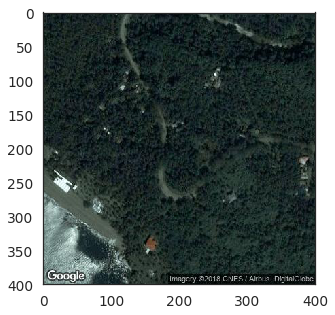

Embedding size: torch.Size([1, 4096])
Cosine similarity between 2 high nightlight intensity images: tensor([0.9768])
Cosine similarity between 2 low nightlight intensity images: tensor([0.9632])
Cosine similarity between 1 low and 1 high: tensor([0.5031])
Cosine similarity 1 high and 1 low: tensor([0.6410])


In [6]:
# Get feature embeddings for selected test images
high1_embedding = transfer_utils.get_embedding(high1_file, model, gpu=True)
high2_embedding = transfer_utils.get_embedding(high2_file, model, gpu=True)
low1_embedding = transfer_utils.get_embedding(low1_file, model, gpu=True)
low2_embedding = transfer_utils.get_embedding(low2_file, model, gpu=True)

# Display test images
figsize = (5,5)
plt.figure(figsize=figsize)
plt.imshow(mpimg.imread(high1_file))
plt.show()
plt.figure(figsize=figsize)
plt.imshow(mpimg.imread(high2_file))
plt.show()
plt.figure(figsize=figsize)
plt.imshow(mpimg.imread(low1_file))
plt.show()
plt.figure(figsize=figsize)
plt.imshow(mpimg.imread(low2_file))
plt.show()

# Sanity check: Get cosine similarity between feature embeddings
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
print("Embedding size: {}".format(high1_embedding.size()))
print('Cosine similarity between 2 high nightlight intensity images: {0}'.format(cos(high1_embedding,high2_embedding)))
print('Cosine similarity between 2 low nightlight intensity images: {0}'.format(cos(low1_embedding,low2_embedding)))
print('Cosine similarity between 1 low and 1 high: {0}'.format(cos(low1_embedding,high2_embedding)))
print('Cosine similarity 1 high and 1 low: {0}'.format(cos(high1_embedding,low2_embedding)))

## Generate feature embedding per cluster

In [7]:
# Get feature embedding per image
report  = nightlights_unstacked.merge(report, left_on='ID', right_on='id', how='left')
report = transfer_utils.get_embedding_per_image(report, model)
print("Report shape: {}".format(report.shape))

# Sanity check: Get feature embedding for 1 high light intensity image and 1 low intensity image
high = torch.from_numpy(np.array([report[report['label'] == 'high'].iloc[0]['embeddings']]))
low = torch.from_numpy(np.array([report[report['label'] == 'low'].iloc[5]['embeddings']]))

# Sanity Check: Cosine similarity between pairs of images
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
print("Cosine similarity is: {}".format(cos(low, high)))

100%|██████████| 173580/173580 [1:22:22<00:00, 33.23it/s]


Report shape: (173580, 14)
Cosine similarity is: tensor([0.7151])


In [8]:
# Get mean feature embedding per cluster
cluster_embeddings = transfer_utils.get_mean_embedding_per_cluster(report)

# Merge cluster embeddings with DHS indicators
cluster_embeddings = cluster_embeddings.merge(dhs_indicators, left_on='cluster', right_on='Cluster number')
feature_embeddings = cluster_embeddings.mean_embedding.apply(pd.Series)

# Save embeddings 
feature_embeddings.to_csv(feature_embeddings_file)
cluster_embeddings.to_csv(embeddings_indicators_file)

100%|██████████| 1214/1214 [00:01<00:00, 674.02it/s]


## Machine Learning Pipeline

In [6]:
scoring = {
    "r2": "r2",
    'neg_mse': 'neg_mean_squared_error'
}

indicators = [
    'Wealth Index',
    'Log Wealth Index',
    'Education completed (years)',
    'Access to electricity',
    'Access to water (minutes)'
]

In [8]:
# Load embedding features
embeddings_df = pd.read_csv(feature_embeddings_file).iloc[:, 1:]
cluster_embeddings = pd.read_csv(embeddings_indicators_file)
feature_cols = embeddings_df.columns

# Merge with DHS indicators
embeddings_df['Cluster number'] = cluster_embeddings['Cluster number']
data = embeddings_df.merge(cluster_embeddings, on='Cluster number')

## t-SNE Visualization

In [11]:
embeddings = data.iloc[:, :4096]
feature_cols = embeddings.columns

embeddings['Cluster number'] = data['Cluster number']
embeddings['Wealth Index'] = data['Wealth Index']

# Sanity check embeddings
data.iloc[:, [-7, 0, 1, 2]].tail(3)

,mean_embedding,0,1,2
1210,"[0.30419865, 0.31373227, 0.8057267, 0.17085838...",0.304199,0.313732,0.805727
1211,"[0.47769687, 0.37825266, 1.0952741, 0.2098707,...",0.477697,0.378253,1.095274
1212,"[0.24996638, 0.30918396, 0.8428106, 0.13828953...",0.249966,0.309184,0.842811


In [12]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embeddings[feature_cols].values)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1213 samples in 0.354s...
[t-SNE] Computed neighbors for 1213 samples in 6.238s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1213
[t-SNE] Computed conditional probabilities for sample 1213 / 1213
[t-SNE] Mean sigma: 1.838341
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.270271
[t-SNE] KL divergence after 300 iterations: 0.715780


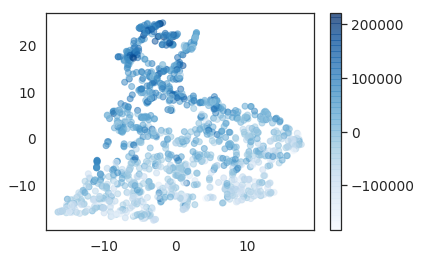

In [13]:
embeddings['x-tsne'] = tsne_results[:,0]
embeddings['y-tsne'] = tsne_results[:,1]

f, ax = plt.subplots()
points = ax.scatter(embeddings['x-tsne'], embeddings['y-tsne'], c=embeddings['Wealth Index'], cmap='Blues', alpha=0.5)
f.colorbar(points)

## Machine Learning Pipeline

### Ridge Regression

Uses best model from `trial4_version3`. Learning rate is 1e-6, with 5 nightlight intensity bins. 

Socioeconomic indicator: Wealth Index
test_r2 : 0.5929
[0.63549249 0.53992238 0.61405551 0.5981024  0.57684202]
train_neg_mse : -1454914176.9446
[-1.44673423e+09 -1.45232160e+09 -1.42577953e+09 -1.51979621e+09
 -1.42993932e+09]
fit_time : 42.1667
[44.17488027 46.41756415 46.88427925 47.67361832 25.68306208]
test_neg_mse : -2025936505.1869
[-1.91644470e+09 -1.88345832e+09 -2.36851275e+09 -1.95936151e+09
 -2.00190525e+09]
train_r2 : 0.7106
[0.70833023 0.72432514 0.70010984 0.70032161 0.71998123]
score_time : 0.0820
[0.12466407 0.06892586 0.06483459 0.0644815  0.0871644 ]
Best estimator: Pipeline(memory=None,
     steps=[('regressor', Ridge(alpha=0.23233444867279784, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=True, random_state=42, solver='auto',
   tol=0.001))])


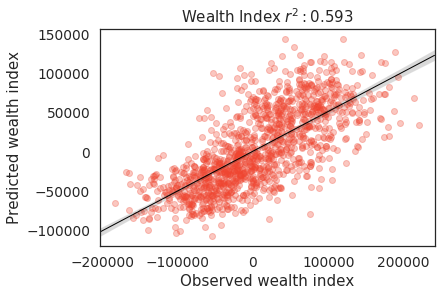

Socioeconomic indicator: Log Wealth Index
test_r2 : 0.4533
[0.58926901 0.40968988 0.2236646  0.51374401 0.52996329]
train_neg_mse : -0.1712
[-0.20100429 -0.19638165 -0.06202458 -0.19575265 -0.20062124]
fit_time : 40.9872
[46.56004477 45.26229906 45.57211161 45.35656953 22.18511057]
test_neg_mse : -0.2080
[-0.0745888  -0.09853271 -0.69268736 -0.09860972 -0.07562464]
train_r2 : 0.4885
[0.43818844 0.45777171 0.65241308 0.44575195 0.44824847]
score_time : 0.0612
[0.038445   0.05487561 0.06775761 0.09751391 0.04743481]
Best estimator: Pipeline(memory=None,
     steps=[('regressor', Ridge(alpha=3.4647045830997407, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=42, solver='auto',
   tol=0.001))])


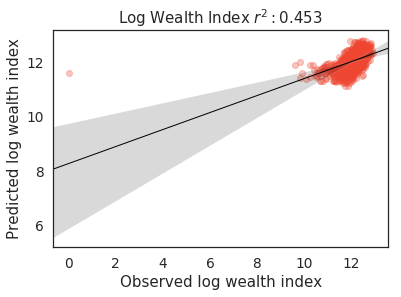

Socioeconomic indicator: Education completed (years)
test_r2 : 0.4396
[0.47739205 0.36778162 0.50237347 0.46854789 0.38200534]
train_neg_mse : -2.2589
[-2.24355808 -2.40984489 -2.22789148 -2.26789748 -2.14552416]
fit_time : 24.8871
[27.29887247 28.27229881 28.60831141 26.53457427 13.72129965]
test_neg_mse : -3.0449
[-2.82566859 -2.71357727 -3.40708937 -3.06548016 -3.21272823]
train_r2 : 0.5897
[0.59416108 0.58552266 0.56935447 0.58347066 0.61577126]
score_time : 0.0393
[0.04040194 0.04614806 0.04359508 0.05833077 0.00822258]
Best estimator: Pipeline(memory=None,
     steps=[('regressor', Ridge(alpha=0.23233444867279784, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=True, random_state=42, solver='auto',
   tol=0.001))])


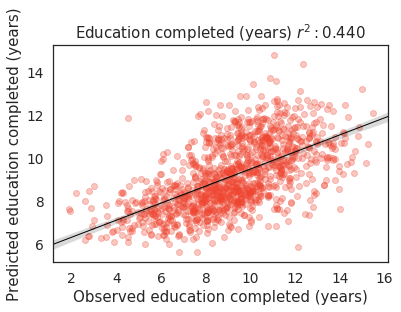

Socioeconomic indicator: Access to electricity
test_r2 : 0.1970
[0.20143126 0.20559833 0.2454256  0.2665368  0.06583376]
train_neg_mse : -0.0128
[-0.01199203 -0.01583517 -0.01023055 -0.01250998 -0.01341454]
fit_time : 17.8918
[19.82313347 19.62725019 19.71933174 20.05258656 10.23673224]
test_neg_mse : -0.0165
[-0.01518686 -0.01442354 -0.02656291 -0.01562645 -0.01046417]
train_r2 : 0.3944
[0.44597885 0.27536814 0.41376127 0.40652427 0.43053126]
score_time : 0.0325
[0.03748822 0.02723145 0.04434609 0.02415991 0.02930927]
Best estimator: Pipeline(memory=None,
     steps=[('regressor', Ridge(alpha=3.4647045830997407, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=42, solver='auto',
   tol=0.001))])


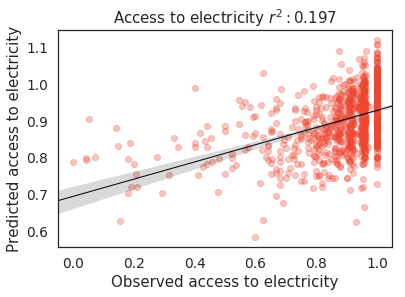

Socioeconomic indicator: Access to water (minutes)
test_r2 : 0.0472
[0.03378168 0.06052378 0.04353373 0.04748407 0.0508093 ]
train_neg_mse : -60.5513
[-42.08379934 -72.67349392 -58.97679212 -59.99988165 -69.02229023]
fit_time : 29.3491
[33.67132735 32.63127756 34.54509139 32.07949853 13.81838226]
test_neg_mse : -64.3915
[-144.78021164  -14.01590198  -69.08008782  -65.78075678  -28.30045443]
train_r2 : 0.1005
[0.09749207 0.09589407 0.10651497 0.10291096 0.09963266]
score_time : 0.0459
[0.04502654 0.0475595  0.05115914 0.06298041 0.02274156]
Best estimator: Pipeline(memory=None,
     steps=[('regressor', Ridge(alpha=3.4647045830997407, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=True, random_state=42, solver='auto',
   tol=0.001))])


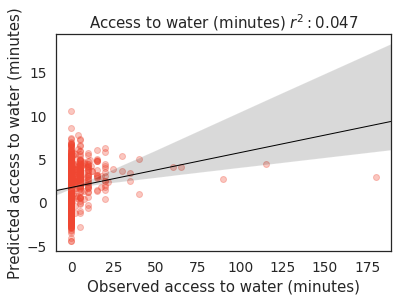

In [19]:
predictions = model_utils.evaluate_model(
    data=data,
    feature_cols=feature_cols, 
    indicator_cols=indicators, 
    scoring=scoring,
    model_type='ridge', 
    refit='r2', 
    search_type='grid', 
    n_splits=5 
)

### Ridge Regression

Uses best model from `trial3_version2`. Learning rate is 1e-6, with 3 nightlight intensity bins. 

Socioeconomic indicator: Wealth Index
test_r2 : 0.5794
[0.63457188 0.51098879 0.59938193 0.58202489 0.57012624]
train_neg_mse : -1373612350.4192
[-1.40596993e+09 -1.40064104e+09 -1.29476538e+09 -1.37388556e+09
 -1.39279984e+09]
fit_time : 29.1991
[33.39480901 34.0669539  33.96581602 34.37238669 10.19577956]
test_neg_mse : -2090634996.3044
[-1.92128490e+09 -2.00190619e+09 -2.45856340e+09 -2.03774377e+09
 -2.03367672e+09]
train_r2 : 0.7269
[0.71654854 0.73413497 0.72766659 0.72909275 0.72725409]
score_time : 0.0300
[0.04361749 0.03745484 0.03729486 0.01380062 0.01799083]
Best estimator: Pipeline(memory=None,
     steps=[('regressor', Ridge(alpha=1.49816047538945, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001))])


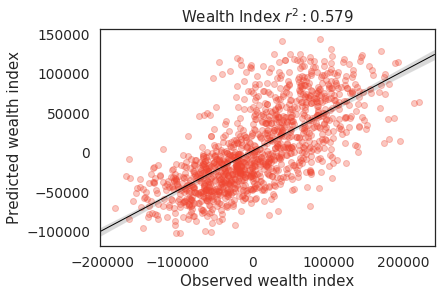

Socioeconomic indicator: Log Wealth Index
test_r2 : 0.4344
[0.59618518 0.35106017 0.22127055 0.51079279 0.49244501]
train_neg_mse : -0.1719
[-0.20408555 -0.19776819 -0.05639405 -0.19867141 -0.20234941]
fit_time : 25.7842
[29.87972999 29.11291504 29.0425446  29.53005123 11.35594821]
test_neg_mse : -0.2115
[-0.07333282 -0.108319   -0.69482345 -0.09920821 -0.081661  ]
train_r2 : 0.4897
[0.42957625 0.45394334 0.68396664 0.43748786 0.44349564]
score_time : 0.0457
[0.01932526 0.07497215 0.06804299 0.04043818 0.02572346]
Best estimator: Pipeline(memory=None,
     steps=[('regressor', Ridge(alpha=1.49816047538945, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001))])


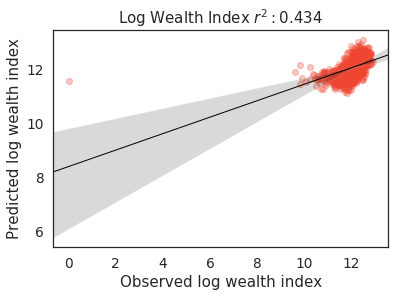

Socioeconomic indicator: Education completed (years)
test_r2 : 0.4308
[0.47023722 0.35630061 0.48799754 0.46095515 0.37846467]
train_neg_mse : -2.3144
[-2.13266121 -2.44119016 -2.30944911 -2.35856192 -2.33010423]
fit_time : 26.1947
[31.38875294 29.36451745 30.13610148 30.54862285  9.53558517]
test_neg_mse : -3.0946
[-2.86435374 -2.76285549 -3.50551675 -3.109276   -3.2311349 ]
train_r2 : 0.5795
[0.6142213  0.58013148 0.55358959 0.56681894 0.58271594]
score_time : 0.0444
[0.02459335 0.08705568 0.04893279 0.04321909 0.01819515]
Best estimator: Pipeline(memory=None,
     steps=[('regressor', Ridge(alpha=1.49816047538945, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001))])


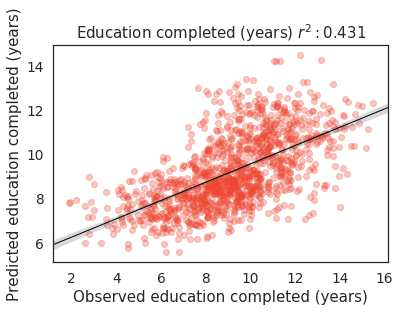

Socioeconomic indicator: Access to electricity
test_r2 : 0.1865
[0.1881262  0.20090911 0.21969634 0.25006332 0.07371531]
train_neg_mse : -0.0118
[-0.01149298 -0.0136411  -0.00908735 -0.01122625 -0.01372372]
fit_time : 26.7573
[30.90495753 31.69501114 31.4271071  30.65316463  9.10604596]
test_neg_mse : -0.0168
[-0.01543989 -0.01450868 -0.02746864 -0.01597742 -0.01037589]
train_r2 : 0.4418
[0.46903451 0.37577064 0.47926991 0.46742452 0.41740602]
score_time : 0.0206
[0.03007913 0.02024102 0.01959658 0.02088189 0.01212025]
Best estimator: Pipeline(memory=None,
     steps=[('regressor', Ridge(alpha=2.9279757672456204, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=42, solver='auto',
   tol=0.001))])


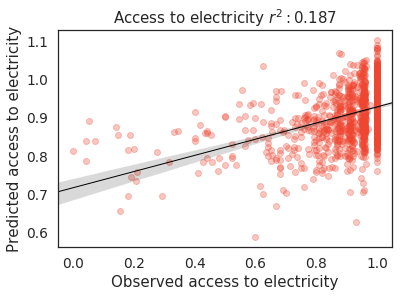

Socioeconomic indicator: Access to water (minutes)
test_r2 : 0.0401
[0.03348868 0.05392188 0.04680508 0.03189152 0.03441798]
train_neg_mse : -60.5956
[-42.94560569 -72.58133319 -59.09821494 -59.48645678 -68.86613982]
fit_time : 24.5934
[28.07924438 27.68870139 29.65437579 28.2389214   9.3055222 ]
test_neg_mse : -64.6858
[-144.82411636  -14.11439483  -68.84381683  -66.85757827  -28.78916752]
train_r2 : 0.0986
[0.0790102  0.09704061 0.10467545 0.11058744 0.10166958]
score_time : 0.0372
[0.03349376 0.05427861 0.02742243 0.04754329 0.0230751 ]
Best estimator: Pipeline(memory=None,
     steps=[('regressor', Ridge(alpha=3.8028572256396647, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=True, random_state=42, solver='auto',
   tol=0.001))])


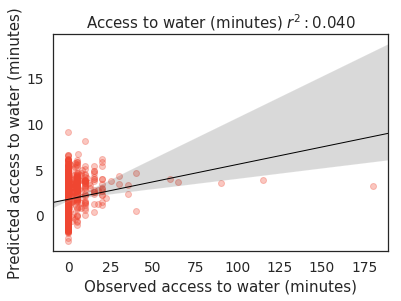

In [11]:
predictions = model_utils.evaluate_model(
    data=data,
    feature_cols=feature_cols, 
    indicator_cols=indicators, 
    scoring=scoring,
    model_type='ridge', 
    refit='r2', 
    search_type='grid', 
    n_splits=5 
)